# [Multilevel Modeling](https://en.wikipedia.org/wiki/Multilevel_model)
Idea: Decompose the sum of random numbers into its contributions

for a given set of $x_i$ and $a_{ik}$ with
$$x_i = \Sigma_{j=0}^n \Sigma_{k=1}^{m_j} a_{ik}y_{jk}$$ 
with
* $m_j$ being the number of contributers of layer j
* $y_{jk}$ being the k-th contribution of layer j
* $m_0 = 1$ by default
* $a_{ik} \in \{0, 1\}$
* $\Sigma a_{ik} = 1$ only one contributer per layer

calculate the Distributions $y_{k} \sim N(μ_{k}, σ_{k})$
Boundary conditions:
* $\Sigma _{k} μ_k = 0$ via $μ_{m_j} = -\Sigma_{k = 1}^{m_j-1} μ_{k}$

In [45]:
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import logging
import seaborn as sns
import pymc as pm
import arviz as az
import bambi as bmb
import pandas as pd

%matplotlib inline
plt.style.use('default')

#logging.basicConfig(format='%(message)s', level=logging.INFO)
warnings.filterwarnings("ignore", module="scipy")

In [8]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.2


## Initialize the data

In [9]:
n_samples = 1000

n_contributers = [2, 4] # one influencer in level 1 and 4 on level 1

## setup the individual random generators

In [10]:
def align_coefficients(coefs):
    """ensure that the average over all contributers per level is 0"""
    mem = {}
    for level, lcoefs in coefs.items():
        avg = np.mean([m for (m, s) in lcoefs.values()])
        mem[level] = {k: (m-avg, s) for k, (m,s) in lcoefs.items()}
    
    return mem
def gen_contributer_coefficients(n_contributers, contributer_avg, contributer_sig):
    """creates for n_contributers the average and standard deviation
    Input:
    * n_contributers: list with number of influencers for each level
    * contributer_avg: average for the average of the influencers
    * contributer_sig: average for the stdev for the influencers (lognormal distribution) 
     
    Output:
    Dictionary {level : { influencer: (mu, sigma)}} with the coefficients for every
    influencer in each level
    """
    assert n_contributers[0] == 1, "First level is allowed to have one contributer"
    return align_coefficients({lvl : {i : (np.random.normal(contributer_avg), np.random.lognormal(contributer_sig)) for i in range(num)} for lvl, num in enumerate(n_contributers)})

def print_coefficients(contributer_coefficients):
    contributer_coefficients = align_coefficients(contributer_coefficients)
    for m, stage in contributer_coefficients.items():
        for i, (mu, sig) in stage.items():
            print(f"Stage {m}: Contributer {i} mu={mu:.2f}, sig={sig:.2f}")

In [11]:
# easy as a start
cc_02 = {0: {    0: (0, 5)},
        1: {    0: (0, 1),
                1: (0, 1),
                2: (0, 1),
                3: (4, 2)}}
cc_01 = { 
        0: {    0 : (0, 5)},
        1: {    0: (1, 1),
                1: (-1, 1)}}

In [12]:
print_coefficients(cc_02)

Stage 0: Contributer 0 mu=0.00, sig=5.00
Stage 1: Contributer 0 mu=-1.00, sig=1.00
Stage 1: Contributer 1 mu=-1.00, sig=1.00
Stage 1: Contributer 2 mu=-1.00, sig=1.00
Stage 1: Contributer 3 mu=3.00, sig=2.00


## Create the Data

In [13]:
def gen_data(contributer_coefficients, n_samples):
    """generate random data.
    The first level defines the baseline that holds for all random numbers
    
    Inputs:
    * n_samples: number of samples
    * contributer_coefficients: dictionary with (mean,sig) per level per contributer
    
    Outputs:
    * data: array with the final number
    * contributers: matrix defining the contributers, first column is for the first level"""
    
    assert len(cc_01[0]) == 1, "Level 0 defines the baseline. It should have exactly one contributer"
    #data = np.random.normal(gen_avg, gen_sig, n_samples)
    data = np.zeros((n_samples, ))
    contributers = np.zeros((n_samples, len(contributer_coefficients)))
    for lvl, cdict in contributer_coefficients.items():
        print(f"creating level {lvl}")
        lvl_influencers = len(cdict) #number of influencers in this level
        lvldata = np.zeros((n_samples, lvl_influencers))

        for i, (mu,sig) in cdict.items():
            lvldata[:,i] = np.random.normal(mu, sig, n_samples)

        selection = np.random.randint(low=0,
                                    high=lvl_influencers,
                                    size=(n_samples))
        contributers[:, lvl] = selection
        
        data += np.array([lvldata[row, col] for row, col in enumerate(selection)])
        # Note: The first level 
    return data, contributers[:, 1:]

# Modeling

use [Radon Analysis](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html) as reference

In [19]:
# generate the data
data0, contributers = gen_data(n_samples=n_samples,
                              contributer_coefficients=cc_01)

contributers0 = contributers.squeeze(-1)

creating level 0
creating level 1


In [23]:
with pm.Model() as model_ref:
    
    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # Data
    value = pm.Normal("value", 
                      mu=a_mu,
                      sigma = a_sigma,
                      observed = data0)

In [26]:
with model_ref:
    prior_checks = pm.sample_prior_predictive()

Sampling: [a_mu, a_sigma, value]
Sampling: [a_mu, a_sigma, value]


In [28]:
with model_ref:
    ref_trace  = pm.sample()

Auto-assigning NUTS sampler...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_mu, a_sigma]
NUTS: [a_mu, a_sigma]


c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 280 seconds.
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 280 seconds.


In [31]:
az.summary(ref_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_mu,0.02,0.16,-0.26,0.32,0.0,0.0,3874.15,2475.96,1.0
a_sigma,5.11,0.12,4.89,5.32,0.0,0.0,3717.03,2681.69,1.0


array([[<Axes: title={'center': 'a_mu'}>,
        <Axes: title={'center': 'a_mu'}>],
       [<Axes: title={'center': 'a_sigma'}>,
        <Axes: title={'center': 'a_sigma'}>]], dtype=object)

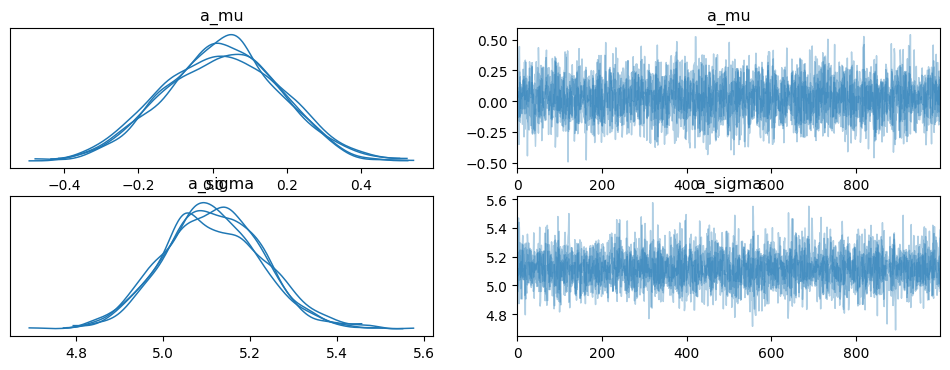

In [32]:
az.plot_trace(ref_trace,
              compact="true",
    chain_prop={"ls": "-"},)

# First model

In [38]:
n_contributers=2

In [52]:
data = pd.DataFrame({"value" : data0, "contributer" : contributers0.squeeze()})

In [54]:
model = bmb.Model("value ~ 1 + (1|contributer)", data)
model

       Formula: value ~ 1 + (1|contributer)
        Family: gaussian
          Link: mu = identity
  Observations: 1000
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0238, sigma: 12.7913)
        
        Group-level effects
            1|contributer ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 12.7913))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 5.1165)

In [55]:
results=model.fit()

Auto-assigning NUTS sampler...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|contributer_sigma, 1|contributer_offset]
NUTS: [sigma, Intercept, 1|contributer_sigma, 1|contributer_offset]


c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [41]:
with pm.Model() as model0:
    contributer_data_idx = pm.ConstantData("contributer_data_idx", contributers0, dims="obs_id")
    #datam = pm.ConstantData("data_idx", data0, dims="obs_id")

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # contributions
    con_sigmas = pm.Exponential("con_sigmas", 1, shape=n_contributers)
    cons = pm.Normal("cons", mu=0, sigma = con_sigmas, shape=n_contributers)

    # expected value
    y_hat = pm.Deterministic(a_mu + cons[contributer_data_idx], dims = "obs_id")
    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = a_sigma,
                      observed = data0)



KeyError: "Dimensions {'contributer_idx'} are unknown to the model and cannot be used to specify a `shape`."

In [37]:
n_contributers

[2, 4]